In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from data import *
from baseline_smc import *
from plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
import datetime
import time 
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

('probtorch:', '0.0+5a2c637', 'torch:', '1.0.0.dev20181029', 'cuda:', True)


In [2]:
## Dataset parameters
num_series = 1
## range of length of tracjectories, need to be positive integers
T_min = 50
T_max = 60
K = 4
D = 2
dt = 5
Boundary = 30
noise_ratio = 2.0

## Model Parameters
num_particles = 50
num_particles_smc = 30
NUM_HIDDEN = 32
NUM_LATENTS = K*K
NUM_OBS = 2 * D

NUM_EPOCHS = 400
LEARNING_RATE = 1e-3
CUDA = False
RESTORE = False
PATH_ENC = "baseline/1shot_enc-%dIS-enc-%s" % (num_particles, datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

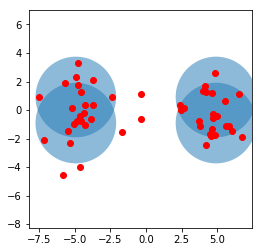

In [3]:
T = 50
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio       
init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
init_v = init_v / v_norm * dt ## to make the velocity lying on a circle
STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)

plot_clusters(Y.data.numpy(), mu_ks.data.numpy(), cov_ks.data.numpy(), K)

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, prior):
        A_sample = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        variational = F.softmax(self.latent_dir(hidden), -1).sum(0).view(K, K) + prior
        for k in range(K):
            A_sample[k] = Dirichlet(variational[k]).sample()
        return variational, A_sample

In [5]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [6]:
KLs = []
EUBOs = []
ESSs = []
ELBOs = []
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    optimizer.zero_grad()
    alpha_trans_0 = initial_trans_prior(K)
    init_v = init_velocity(dt)
    T = np.random.randint(T_min, T_max)
    STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)
    enc, eubo, kl, ess, variational, elbo = oneshot_sampling(enc, alpha_trans_0, Pi, mu_ks, cov_ks, Y, T, D, K, num_particles, num_particles_smc)
    eubo.backward()
    KLs.append(kl.item())
    EUBOs.append(eubo.item())
    ESSs.append(ess)
    ELBOs.append(elbo.item())
#     log_qs.append(loss_infer.item())
    optimizer.step()
    time_end = time.time()
    print('epoch : %d, eubo : %f, elbo : %f,  KL : %f (%ds)' % (epoch, eubo, elbo, kl, time_end - time_start))

if RESTORE:
    enc.load_state_dict(torch.load(PATH_ENC))
else:
    torch.save(enc.state_dict(), PATH_ENC)
    save_params(KLs, EUBOs, ESSs, PATH_ENC)

epoch : 0, eubo : -243.071594, elbo : -266.204285,  KL : 29.774643 (4s)
epoch : 1, eubo : -251.399277, elbo : -288.891510,  KL : 46.864288 (4s)
epoch : 2, eubo : -238.403931, elbo : -268.338409,  KL : 41.484852 (4s)
epoch : 3, eubo : -214.431793, elbo : -228.960495,  KL : 24.510698 (3s)
epoch : 4, eubo : -244.086197, elbo : -258.361481,  KL : 29.318493 (4s)
epoch : 5, eubo : -243.315643, elbo : -265.992676,  KL : 36.562729 (4s)
epoch : 6, eubo : -268.303955, elbo : -286.779114,  KL : 36.537216 (4s)
epoch : 7, eubo : -265.375122, elbo : -284.834991,  KL : 31.783752 (4s)
epoch : 8, eubo : -266.987701, elbo : -287.415436,  KL : 38.918880 (4s)
epoch : 9, eubo : -244.266586, elbo : -269.765839,  KL : 35.420334 (3s)
epoch : 10, eubo : -244.785553, elbo : -263.099670,  KL : 33.607166 (4s)
epoch : 11, eubo : -250.860947, elbo : -269.795502,  KL : 35.876801 (3s)
epoch : 12, eubo : -238.077408, elbo : -253.320160,  KL : 33.056644 (3s)
epoch : 13, eubo : -271.702515, elbo : -290.839020,  KL : 43.

NameError: global name 'fess' is not defined

In [ ]:
# plot_dirs(variational, alpha_trans_0, Zs_true, T, K, vmax=15)

In [ ]:
# conjugate_post = alpha_trans_0 + pairwise(Z_true, T).sum(0)
# variational = alpha_trans_0 + latents_dirs
# conjugate_post.sum()

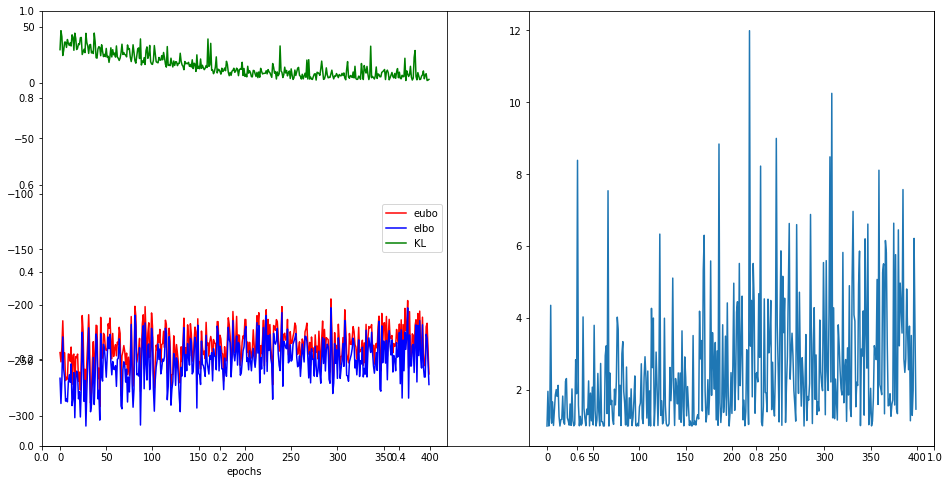

In [9]:
def plot_results(EUBOs, ELBOs, KLs, ESSs, PATH_ENC):
    fig, ax = plt.subplots(figsize=(16, 8))
    ax1 = fig.add_subplot(1,2,1)
    x = np.arange(len(EUBOs))
    ax1.plot(EUBOs, 'r-', label='eubo')
    ax1.plot(ELBOs, 'b-', label='elbo')
    ax1.plot(KLs, 'g-', label='KL')
    ax1.legend()
    ax1.set_xlabel('epochs')
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(np.array(ESSs))
    fig.savefig(PATH_ENC + 'results.png')

plot_results(EUBOs, ELBOs, KLs, ESSs, PATH_ENC)